# LSTM On Amazon Food Reviews


In [1]:

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)


Using TensorFlow backend.


In [0]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization


In [0]:
import warnings
warnings.filterwarnings('ignore')

## Loading Amazon Food Reviews

In [6]:

# using the SQLite Table to read data.
con = sqlite3.connect('drive/My Drive/amazon/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Preprocessing 

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
final['Text']=final['Text'].str.lower()

In [10]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","i grew up reading these sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,this is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,this is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,this is a book of poetry about the months of t...


### Creating Sub-dataframe

In [12]:
#creating subset dataframe
sub_data=final[0:100000]
sub_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","i grew up reading these sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,this is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,this is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,this is a book of poetry about the months of t...


In [0]:
#array that contains +ve=1 and -ve=0 reviews
y=np.array(sub_data['Score'])

In [0]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.2)


In [0]:
from sklearn.model_selection import train_test_split


#### Splitting to train and test

In [0]:
# split the data set into train and test
x_train, x_test, y_train, y_test = train_test_split(sub_data['Text'], y, test_size=0.3, random_state=0)

## Converting text into sequence of words

In [0]:
#source:https://keras.io/preprocessing/text/
#source:https://github.com/shshnk158/Amazon-Fine-Food-Reviews-Prediciton/blob/master/LSTM_Amazon_Food_Reviews.ipynb


from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)

In [0]:
x_test = tokenizer.texts_to_sequences(x_test)

In [0]:
print(x_train[1])
print(type(x_train[1]))
print(len(x_train[1]))

[1300, 11, 1573, 48, 61, 36, 7, 89, 8, 1, 1811, 7, 4183, 296, 2, 146, 6, 1979, 3866, 18, 2, 17, 9, 8, 4, 1845, 1035, 10, 10, 56, 5, 1, 2600]
<class 'list'>
33


In [0]:
# truncate and/or pad input sequences
max_review_length = 600
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print(x_train.shape)
print(x_train[1])

(70000, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

## LSTM

In [0]:
top_words = 5000

In [0]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history=model.fit(x_train, y_train, nb_epoch=10, batch_size=64,validation_data=(x_test, y_test),verbose=1)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 1563s 22ms/step - loss: 0.0662 - acc: 0.9766 - val_loss: 0.2475 - val_acc: 0.9244
Epoch 2/10
70000/70000 [==============================] - 2261s 32ms/step - loss: 0.0592 - acc: 0.9793 - val_loss: 0.2679 - val_acc: 0.9271
Epoch 3/10
70000/70000 [==============================] - 2426s 35ms/step - loss: 0.0523 - acc: 0.9825 - val_loss: 0.2803 - val_acc: 0.9263
Epoch 4/10
70000/70000 [==============================] - 1576s 23ms/step - loss: 0.0466 - acc: 0.9847 - val_loss: 0.3173 - val_acc: 0.9237
Epoch 5/10
70000/70000 [==============================] - 1575s 22ms/step - loss: 0.0424 - acc: 0.9860 - val_loss: 0.3220 - val_acc: 0.9233
Epoch 6/10
70000/70000 [==============================] - 1582s 23ms/step - loss: 0.0412 - acc: 0.9866 - val_loss: 0.3310 - val_acc: 0.9230
Epoch 7/10
70000/70000 [==============================] - 1586s 23ms/step - loss: 0.0427 - acc: 0.9860 - val_l

In [0]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [0]:
def plot_loss_acc_curves(history):
# Loss Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
# Accuracy Curves 
  plt.figure(figsize=[8,6])
  plt.plot(history.history['acc'],'r',linewidth=3.0)
  plt.plot(history.history['val_acc'],'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

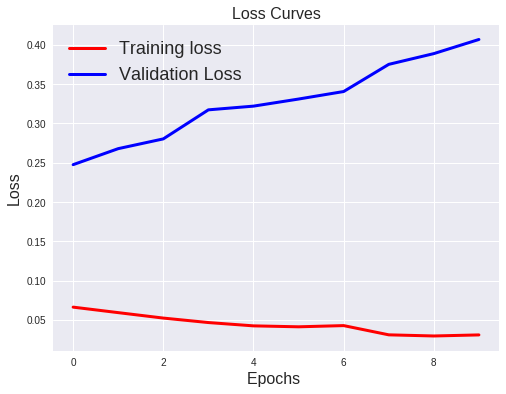

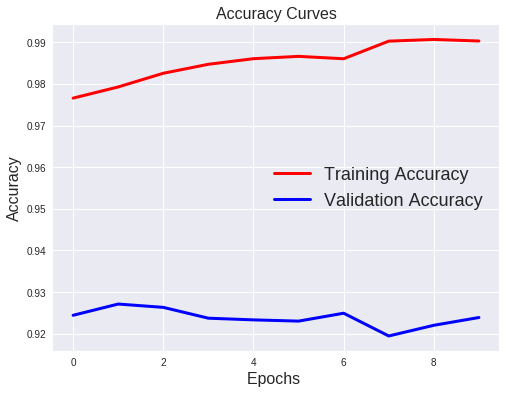

In [0]:
plot_loss_acc_curves(history)

## Building 2-layer LSTM with 50k data points

In [13]:
#creating subset dataframe
sub_data2=final[0:50000]
sub_data2.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","i grew up reading these sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,this is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,this is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,this is a book of poetry about the months of t...


In [0]:
#array that contains +ve=1 and -ve=0 reviews
y=np.array(sub_data2['Score'])

#### Splitting to train and test

In [0]:
from sklearn.model_selection import train_test_split


In [0]:
# split the data set into train and test
x_train, x_test, y_train, y_test = train_test_split(sub_data2['Text'], y, test_size=0.3, random_state=0)

#### Converting text into sequence of words

In [0]:
#source:https://keras.io/preprocessing/text/
#source:https://github.com/shshnk158/Amazon-Fine-Food-Reviews-Prediciton/blob/master/LSTM_Amazon_Food_Reviews.ipynb


from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)

In [0]:
x_test = tokenizer.texts_to_sequences(x_test)

In [19]:
print(x_train[1])
print(type(x_train[1]))
print(len(x_train[1]))

[2, 114, 9, 41, 69, 3, 2, 272, 2, 153, 4, 31, 453, 318, 13, 604, 369, 5, 1, 1024, 477, 452, 3, 111, 14, 24, 22, 1239, 856, 2515, 336, 123, 49, 57, 612, 2979, 63, 10, 10, 782, 82, 1717, 1120, 28, 91, 79, 2, 16, 583, 613, 34, 123, 3, 64, 120, 135, 7, 6]
<class 'list'>
58


In [20]:
# truncate and/or pad input sequences
max_review_length = 600
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print(x_train.shape)
print(x_train[1])

(35000, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

### 2LAYER LSTM

In [22]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
history=model.fit(x_train, y_train, nb_epoch=10, batch_size=64,validation_data=(x_test, y_test),verbose=1)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 1545s 44ms/step - loss: 0.2852 - acc: 0.8903 - val_loss: 0.2273 - val_acc: 0.9117
Epoch 2/10
35000/35000 [==============================] - 1558s 45ms/step - loss: 0.1880 - acc: 0.9276 - val_loss: 0.2414 - val_acc: 0.8999
Epoch 3/10
35000/35000 [==============================] - 1562s 45ms/step - loss: 0.1640 - acc: 0.9390 - val_loss: 0.2179 - val_acc: 0.9147
Epoch 4/10
35000/35000 [==============================] - 1553s 44ms/step - loss: 0.1390 - acc: 0.9484 - val_loss: 0.2206 - val_acc: 0.9156
Epoch 5/10
35000/35000 [==============================] - 1546s 44ms/step - loss: 0.1212 - acc: 0.9563 - val_loss: 0.2383 - val_acc: 0.9177
Epoch 6/10
35000/35000 [==============================] - 1551s 44ms/step - loss: 0.1015 - acc: 0.9648 - val_loss: 0.2581 - val_acc: 0.9050
Epoch 7/10
35000/35000 [==============================] - 1550s 44ms/step - loss: 0.0817 - acc: 0.9738 - val_l

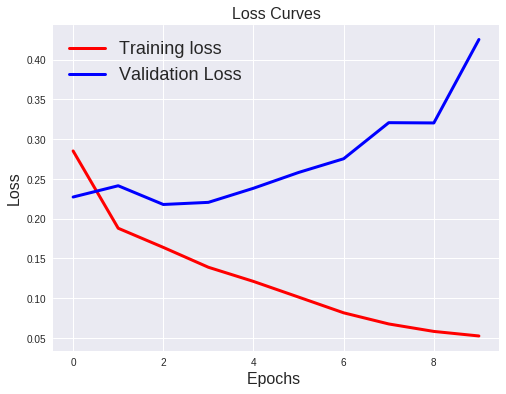

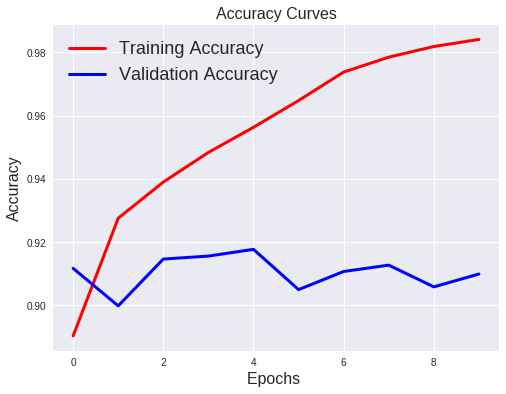

In [25]:
plot_loss_acc_curves(history)

## Summary

* 1-layer LSTM with 100k data points:Accuracy: 92.39%
* 2-layer LSTM with 50k points:  Accuracy: 90.99%
